In [65]:
import statistics
from typing import List

import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy.stats import pearsonr

import afnidespike

In [3]:
plt.rcParams["figure.dpi"] = 150
plt.style.use("ggplot")

In [11]:
def sample_timeseries(num_samples: int, num_spikes: int, seed: int = 42):
    rng = np.random.default_rng(seed)
    data = np.sin(np.linspace(0, 16 * np.pi, num_samples))
    data += rng.normal(0, 0.1, size=num_samples)
    spike_indices = rng.choice(num_samples, num_spikes)
    data[spike_indices] += rng.uniform(10, 100, size=num_spikes)
    data = data.astype("float32")
    return data

In [23]:
def despike_afni(timeseries: np.ndarray, window: int = 25, inplace: bool = False):
    if window not in {9, 25}:
        raise ValueError(f"Invalid window {window}; only 25 or 9 supported")
    
    cleaned = timeseries.astype("float32")
    if not inplace:
        cleaned = cleaned.copy()
    afnidespike.despike(cleaned, int(window == 25))
    return cleaned

In [30]:
def despike_scipy(timeseries: np.ndarray, window: int = 25):
    rolling_med = ndimage.median_filter(timeseries, size=window)
    abs_dev = np.abs(timeseries - rolling_med)
    rolling_mad = ndimage.median_filter(abs_dev, size=window)
    spike_mask = (abs_dev / rolling_mad) > 6.789
    cleaned = np.where(spike_mask, rolling_med, timeseries)
    return cleaned

In [82]:
def despike_py(timeseries: List[float], window: int = 25):
    rolling_med = median_filter(timeseries, window=window)
    abs_dev = [abs(v - med) for v, med in zip(timeseries, rolling_med)]
    rolling_mad = median_filter(abs_dev, window=window)
    cleaned = []
    for ii, v in enumerate(timeseries):
        if abs_dev[ii] / rolling_mad[ii] > 6.789:
            cleaned.append(rolling_med[ii])
        else:
            cleaned.append(v)
    return cleaned


def median_filter(data: List[float], window: int = 25):
    half_window = window // 2
    
    filtered = []
    for ii in range(len(data)):
        start = max(ii - half_window, 0)
        stop = min(ii + half_window, len(data))
        filtered.append(statistics.median(data[start: stop]))
    return filtered

In [71]:
data = sample_timeseries(10_000, 10)

In [72]:
cleaned_afni = despike_afni(data)
cleaned_scipy = despike_scipy(data)
cleaned_py = despike_py(data.tolist())

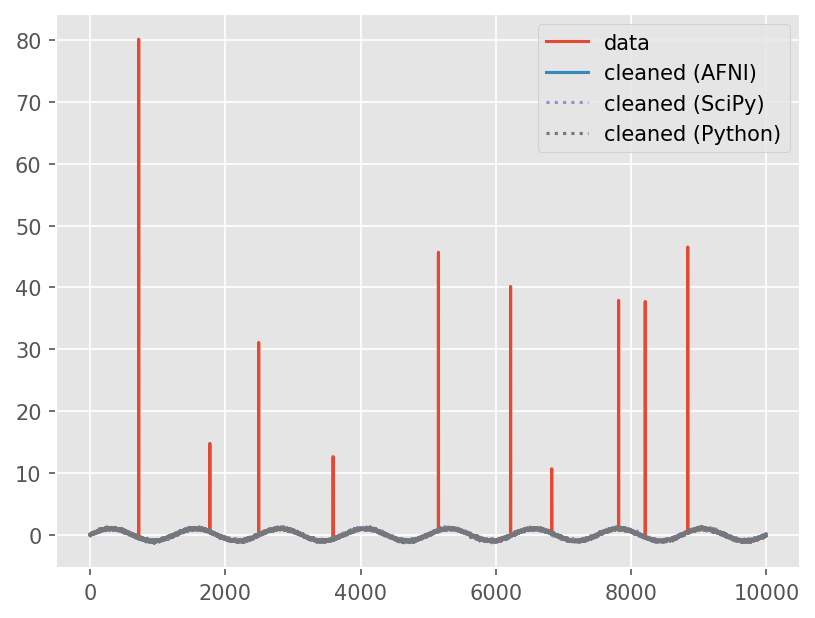

In [73]:
plt.plot(data, label="data")
plt.plot(cleaned_afni, label="cleaned (AFNI)")
plt.plot(cleaned_scipy, ":", label="cleaned (SciPy)")
plt.plot(cleaned_py, ":", label="cleaned (Python)")
plt.legend()

plt.show();

In [92]:
print(pearsonr(cleaned_afni, cleaned_scipy)[0])
print(pearsonr(cleaned_afni, cleaned_py)[0])

0.9999067612044648
0.9998955263415674


In [90]:
%timeit -n 100 despike_afni(data)

5.13 ms ± 713 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [91]:
%timeit -n 100 despike_scipy(data)

7.83 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [89]:
%timeit -n 100 despike_py(data)

116 ms ± 5.69 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
